In [1]:
# !pip install openpyxl
# !pip install imbalanced-learn
# !pip3 install ipympl
# !pip install import-ipynb
# !pip install shapely
# !pip install SciencePlots 
# !pip install seaborn
# !pip install tqdm
# !pip install ipywidgets

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os, sys
from numpy import nan
import re
import ipympl
# from IPython.core.display import display, HTML
import ipywidgets
import json
from os import listdir
import glob
import math
from IPython.display import Image, display, HTML
from shapely.geometry import mapping
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, mean_absolute_error, make_scorer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from cubist import Cubist
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LeaveOneOut, cross_validate
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from tqdm import tqdm
import pickle
from imblearn.over_sampling import SMOTE
from scipy.stats import ks_2samp
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_columns = 100
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

In [6]:
import import_ipynb
from SoilPrep import * 

importing Jupyter notebook from SoilPrep.ipynb


# Step 0: Setting up decision paramenters (Data Tree)

In [7]:
# 1. Available smoothing filter types: savgol1 and savgol2 ------------------------ (1)
sg_filters = ['sg1', 'sg2']

# 2. Available window lengths for the smoothing filter ---------------------------- (2)
window_lengths = [0, 1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

# 3. Available preprocessing for Spectral data ------------------------------------ (3)
prepare_spec = ['none', 'fod', 'continuum']
#prepare_spec = ['none', 'fod', 'continuum']

# 4. Number of bands available for resampling spectra ----------------------------- (4) 
nbands_sampling = [0, 5, 10, 20, 30, 40, 50, 100, 200, 500]

# 5. Names of target variables in the dataframe ----------------------------------- (5)
target_names = ['Nitrogen', 'Phosphorus', 'Potassium']

# 6. Available preprocessing for Target data -------------------------------------- (6)
prepare_target = ['none', 'minmax']

# 7. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr', 'randomforest', 'cubist', 'svr', 'ridge', 'gbrt']

# 8. Recorded predictions on test-train data for model accuracy  ------------------ (8)
test_train_predict = ['test', 'testP', 'train', 'trainP']

# Step 1a: Obtaining Spectra (Noise and Outliers removal)

In [8]:
# Colour scheme definition
kado = '#8B7355'
mati = '#A52A2A'
balu = '#F4A460'

In [9]:
maize_spec = pd.read_csv('maize_2018_2019_unl_spectra.csv')
maize_spec.head(5)

,ID,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,...,2451,2452,2453,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,1,0.106430,0.098860,0.088910,0.077947,0.072843,0.093862,0.090015,0.070006,0.090431,0.084056,0.073512,0.073086,0.067475,0.068706,0.068850,0.063061,0.064384,0.066461,0.070936,0.078129,0.069275,0.064903,0.067154,0.065122,0.060868,0.058503,0.059176,0.060199,0.059542,0.056787,0.053711,0.056561,0.059718,0.059836,0.056556,0.059190,0.057359,0.052478,0.053686,0.054506,0.055347,0.055851,0.053617,0.055252,0.058038,0.058547,0.057006,0.056262,0.055866,...,0.056319,0.055844,0.055375,0.055058,0.054726,0.054421,0.054162,0.053836,0.053488,0.053203,0.052905,0.052548,0.052264,0.051997,0.051595,0.051157,0.050832,0.050384,0.049892,0.049764,0.049538,0.049473,0.049243,0.048725,0.048397,0.048044,0.047772,0.047821,0.047637,0.047205,0.046992,0.046813,0.046602,0.046607,0.046481,0.046230,0.045912,0.045301,0.045138,0.045353,0.045184,0.045096,0.045050,0.044625,0.044355,0.044527,0.044399,0.043810,0.043605,0.043599
1,2,0.097093,0.103140,0.083749,0.066028,0.072148,0.087739,0.098567,0.092104,0.062686,0.095519,0.107648,0.072792,0.071982,0.077794,0.071373,0.050405,0.051561,0.051083,0.053461,0.064439,0.047219,0.043872,0.056082,0.057424,0.058312,0.060843,0.060995,0.048972,0.051361,0.049914,0.036760,0.052602,0.054866,0.049009,0.052006,0.052774,0.050657,0.049641,0.054484,0.047719,0.044079,0.048591,0.048487,0.048350,0.048275,0.047974,0.048457,0.048776,0.048339,...,0.047114,0.046864,0.046694,0.046366,0.045964,0.045663,0.045325,0.045112,0.044898,0.044548,0.044306,0.044098,0.043800,0.043470,0.043094,0.042753,0.042579,0.042447,0.042235,0.042065,0.041800,0.041422,0.041198,0.041026,0.040759,0.040543,0.040383,0.040137,0.039915,0.039878,0.039731,0.039409,0.039179,0.038988,0.038808,0.038687,0.038522,0.038289,0.038160,0.038160,0.038003,0.037762,0.037672,0.037440,0.037419,0.037894,0.037886,0.037521,0.037509,0.037503
2,3,0.125163,0.124518,0.127662,0.127982,0.127173,0.115487,0.111536,0.112970,0.100015,0.079823,0.082658,0.102968,0.088516,0.094781,0.094515,0.070130,0.074827,0.079704,0.075530,0.064953,0.070498,0.072435,0.068536,0.068483,0.070248,0.065726,0.058498,0.066385,0.070785,0.069656,0.066325,0.068654,0.066584,0.063986,0.066945,0.068194,0.069426,0.069469,0.065436,0.058559,0.057705,0.061731,0.055525,0.059083,0.065252,0.065030,0.058985,0.062260,0.068849,...,0.055637,0.055295,0.055052,0.054888,0.054461,0.054179,0.054169,0.053794,0.053397,0.053165,0.052658,0.052337,0.052304,0.051942,0.051510,0.051305,0.051045,0.050822,0.050715,0.050409,0.050127,0.049959,0.049740,0.049392,0.049137,0.048937,0.048751,0.048657,0.048485,0.048162,0.048046,0.048203,0.048045,0.047810,0.047612,0.047058,0.046735,0.046689,0.046588,0.046480,0.046410,0.046467,0.046406,0.046281,0.046181,0.046085,0.045880,0.045441,0.045417,0.045704
3,4,0.101250,0.094361,0.086309,0.090478,0.107267,0.088325,0.076786,0.083318,0.080874,0.084091,0.084152,0.079871,0.085310,0.087679,0.079508,0.062870,0.059119,0.068288,0.075749,0.069223,0.066564,0.066067,0.066501,0.067355,0.066727,0.062973,0.059307,0.064315,0.064843,0.063219,0.062928,0.062292,0.062633,0.062704,0.061520,0.063693,0.063807,0.061729,0.061046,0.060998,0.061302,0.061599,0.061438,0.063316,0.064415,0.062895,0.062514,0.061758,0.062089,...,0.063220,0.062894,0.062567,0.062176,0.061807,0.061366,0.060850,0.060529,0.060285,0.059850,0.059491,0.059236,0.058814,0.058425,0.058187,0.057785,0.057324,0.057021,0.056671,0.056601,0.056302,0.055740,0.055415,0.055086,0.054752,0.054657,0.054514,0.054307,0.054005,0.053654,0.053363,0.052884,0.052615,0.052670,0.052539,0.052351,0.052190,0.051985,0.051738,0.051436,0.051306,0.051264,0.051125,0.051135,0.05

In [10]:
maize_tar = pd.read_csv('maize_2018_2019_unl_traits.csv')
maize_tar.head(5)

,ID,Nitrogen,Phosphorus,Potassium,Chlorophyll,Leaf_Dry_Weight,Leaf_Fresh_Weight,Leaf_Area
0,1,2.96,0.22,1.78,476.60,8.46,30.70,1420.57
1,2,3.11,0.48,2.74,492.17,6.69,27.55,1144.10
2,3,2.94,0.39,2.45,428.91,6.16,25.15,898.15
3,4,3.62,0.41,1.94,554.80,7.54,28.90,1387.85
4,5,2.48,0.27,1.41,425.94,12.01,51.35,2269.29


In [11]:
spectra = maize_spec.iloc[:, 101:].copy()
spectra.head(5)

,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,...,2451,2452,2453,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.055956,0.056224,0.056230,0.056243,0.056340,0.056315,0.056343,0.056514,0.056798,0.056925,0.056880,0.056770,0.056714,0.056430,0.056259,0.056374,0.056690,0.056523,0.056239,0.056240,0.056433,0.056425,0.056245,0.056118,0.056085,0.056085,0.056205,0.056685,0.056676,0.056448,0.056371,0.056382,0.056366,0.056382,0.056533,0.056689,0.056638,0.056537,0.056943,0.056962,0.056828,0.056927,0.057357,0.057520,0.057525,0.057805,0.058172,0.058529,0.058775,0.058803,...,0.056319,0.055844,0.055375,0.055058,0.054726,0.054421,0.054162,0.053836,0.053488,0.053203,0.052905,0.052548,0.052264,0.051997,0.051595,0.051157,0.050832,0.050384,0.049892,0.049764,0.049538,0.049473,0.049243,0.048725,0.048397,0.048044,0.047772,0.047821,0.047637,0.047205,0.046992,0.046813,0.046602,0.046607,0.046481,0.046230,0.045912,0.045301,0.045138,0.045353,0.045184,0.045096,0.045050,0.044625,0.044355,0.044527,0.044399,0.043810,0.043605,0.043599
1,0.047417,0.047152,0.047233,0.047385,0.047575,0.048162,0.048443,0.048123,0.047449,0.047899,0.047757,0.047085,0.046758,0.046937,0.047465,0.047869,0.047417,0.047159,0.047582,0.048300,0.046814,0.046858,0.047639,0.046812,0.046768,0.047083,0.047205,0.046726,0.046699,0.046820,0.046775,0.047127,0.047021,0.046759,0.047028,0.047069,0.047290,0.047738,0.047924,0.047567,0.047000,0.046745,0.047534,0.047585,0.047220,0.047639,0.047728,0.048161,0.048828,0.048473,...,0.047114,0.046864,0.046694,0.046366,0.045964,0.045663,0.045325,0.045112,0.044898,0.044548,0.044306,0.044098,0.043800,0.043470,0.043094,0.042753,0.042579,0.042447,0.042235,0.042065,0.041800,0.041422,0.041198,0.041026,0.040759,0.040543,0.040383,0.040137,0.039915,0.039878,0.039731,0.039409,0.039179,0.038988,0.038808,0.038687,0.038522,0.038289,0.038160,0.038160,0.038003,0.037762,0.037672,0.037440,0.037419,0.037894,0.037886,0.037521,0.037509,0.037503
2,0.062353,0.063031,0.063267,0.063070,0.062948,0.063771,0.063546,0.063024,0.062991,0.062534,0.062851,0.063439,0.063187,0.062541,0.062614,0.063180,0.062546,0.062532,0.062578,0.062161,0.062188,0.062548,0.062730,0.062295,0.062647,0.062798,0.062455,0.062313,0.062375,0.062147,0.061517,0.061696,0.062016,0.062276,0.062460,0.062310,0.062194,0.062312,0.062595,0.062687,0.062591,0.062498,0.062907,0.062856,0.062698,0.063215,0.062964,0.062991,0.063684,0.064320,...,0.055637,0.055295,0.055052,0.054888,0.054461,0.054179,0.054169,0.053794,0.053397,0.053165,0.052658,0.052337,0.052304,0.051942,0.051510,0.051305,0.051045,0.050822,0.050715,0.050409,0.050127,0.049959,0.049740,0.049392,0.049137,0.048937,0.048751,0.048657,0.048485,0.048162,0.048046,0.048203,0.048045,0.047810,0.047612,0.047058,0.046735,0.046689,0.046588,0.046480,0.046410,0.046467,0.046406,0.046281,0.046181,0.046085,0.045880,0.045441,0.045417,0.045704
3,0.063280,0.063820,0.063368,0.063420,0.064046,0.063438,0.063163,0.063105,0.063001,0.063227,0.063564,0.063552,0.062899,0.063034,0.063334,0.063421,0.063391,0.062958,0.062685,0.062924,0.063044,0.062897,0.062625,0.062527,0.062831,0.062960,0.062707,0.062368,0.062491,0.062643,0.062531,0.062908,0.062960,0.062741,0.062659,0.062469,0.062361,0.062479,0.062863,0.062965,0.062953,0.063051,0.063112,0.063144,0.063243,0.063513,0.063770,0.064056,0.064322,0.064388,...,0.063220,0.062894,0.062567,0.062176,0.061807,0.061366,0.060850,0.060529,0.060285,0.059850,0.059491,0.059236,0.058814,0.058425,0.058187,0.057785,0.057324,0.057021,0.056671,0.056601,0.056302,0.055740,0.055415,0.055086,0.054752,0.054657,0.054514,0.054307,0.054005,0.053654,0.053363,0.052884,0.052615,0.052670,0.052539,0.052351,0.052190,0.051985,0.051738,0.051436,0.051306,0.

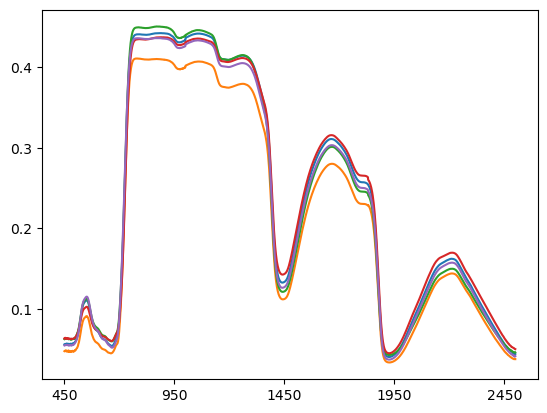

In [12]:
for i in range (0,5,1):
    spectra.iloc[i,:].plot()

# Step 1b: Obtaining Targets (Outliers removal and Normalization)

In [13]:
df = maize_tar
# ------------- Target Isolation ----------------------

clr = ['#F4A460', '#8B7355', '#A52A2A', 'green']

def isolate_targets(df, target_names):
    T=[]
    for i in range (0,len(target_names)):
        T.append(df[target_names[i]])
    return(T)
    
T = isolate_targets(df,target_names) 


def normalize_targets(T):          
    NT =[]
    for i in range(0, len(T)):
        NT.append(min_max_normal(T[i].copy()))
    return(NT)

NT = normalize_targets(T)


# Step 1c: Spectra Preprocessing (Smooth, FOD/Contin, and Resample)

## Savgol smoothing (order 1 and order 2)

In [14]:
# -------------- Smoothed Spectra spec1 (savgol order 1) and spec2 (savgol order 2)  -----------

spec1 = {}
for i in window_lengths:
    spec1[i] = filt_sg(spectra, i, 'sg1')                   

spec2 = {}
for i in window_lengths:
    spec2[i] = filt_sg(spectra, i, 'sg2')

smth_spec = sgsmooth (spectra, 3)    

## First Order Derivative

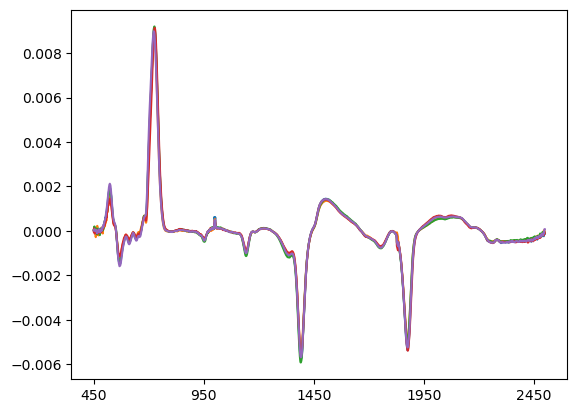

In [15]:
fod_spec = fod(smth_spec)

for i in range (0,5,1):
    fod_spec.iloc[i,:].plot()


## Continuum Removal

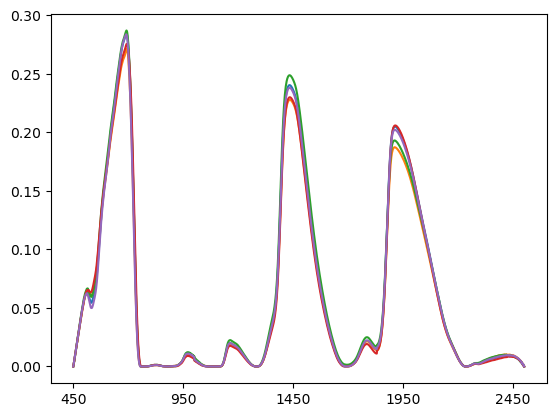

In [16]:
cr_spec = continuum_removed(spec2[51])

for i in range (0,5,1):
    cr_spec.iloc[i,:].plot()
    

## Resampling (n_bands)

### 1. Sampled Original (sampled_spec: sampled clipped_spectra)

In [17]:
sampled_spec = {}
for n in nbands_sampling:
    sampled_spec[n] = resample_spectra (spec2[51], n)

In [18]:
# for i in range (0,5,1):
#     sampled_spec[200].iloc[i,:].plot()

### 2. Sampled Continuum Removed  (sampled_cr)

In [19]:
sampled_cr = {}
for n in nbands_sampling:
    sampled_cr[n] = resample_spectra (cr_spec, n)

In [20]:
# for i in range (0,5,1):
#     sampled_cr[200].iloc[i,:].plot()

### 3. Sampled FOD  (sampled_fod)

In [21]:
sampled_fod = {}
for n in nbands_sampling:
    sampled_fod[n] = resample_spectra (fod_spec, n)

In [22]:
# for i in range (0,10,1):
#     sampled_fod[200].iloc[i,:].plot()

## Visualizing Processed Spectrum (variable samples)

In [23]:
def plot_spec (sample, process):
    x1 = spec2[51].iloc[sample,:]
    x1.plot()
    if process == 'continuum':
        x2 = cr_spec.iloc[sample,:]
        x2.plot()
    else: 
        x3 = fod_spec.iloc[sample,:]*100
        
        x3.plot()
    plt.ylim([-0.6, 0.8])

ipywidgets.interact(plot_spec, sample = (0, 293,1), process = ['fod', 'continuum'])

interactive(children=(IntSlider(value=146, description='sample', max=293), Dropdown(description='process', opt…

<function __main__.plot_spec(sample, process)>

## Correlation between wavelengths and Targets

In [24]:
plt.style.use(['science','notebook','grid'])

def plot_corr (target, spec_cr_fod, n_bands):
    
    i = target_names.index(target)    
    
    if  spec_cr_fod == 'spec':
        r_val, p_val = find_rpval (resample_spectra(spec2[51], n_bands), T[i])
        r_val.iloc[0,:].plot(color = clr[i])
    elif  spec_cr_fod == 'cr':
        r_cr, p_cr = find_rpval (resample_spectra(cr_spec, n_bands), T[i])
        r_cr.iloc[0,:].plot(color = clr[i])
    else:
        r_fod, p_fod = find_rpval (resample_spectra(fod_spec, n_bands), T[i])
        r_fod.iloc[0,:].plot(color = clr[i])
    
    plt.ylim([-0.9, 0.9])

ipywidgets.interact(plot_corr, target = target_names, spec_cr_fod = ['spec', 'cr','fod'], n_bands = nbands_sampling)



interactive(children=(Dropdown(description='target', options=('Nitrogen', 'Phosphorus', 'Potassium'), value='N…

<function __main__.plot_corr(target, spec_cr_fod, n_bands)>

# Step 2:  Parameters for Best Train-Test Split  

In [25]:
# Building Mtree (Model Tree) ----------------------------------

tst_siz = 0.20

rand_t = [None] * (len(T))
err_t = [None] * (len(T))

print('Without Normalization:')
for i in range (0,len(T)):
    rand_t[i], err_t[i] = best_split(spectra.copy(), T[i], tst_siz) 
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_t[i], '\t at randome state =', rand_t[i])
    
rand_nt = [None] * (len(T))
err_nt = [None] * (len(T))

print('After Normalization:')
for i in range (0,len(T)):
    rand_nt[i], err_nt[i] = best_split(spectra.copy(), NT[i], tst_siz)     
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_nt[i], '\t at randome state =', rand_nt[i])
    
    

Without Normalization:
For Nitrogen :test size = 0.2 	 min bin error= 50.0 	 at randome state = 1
For Phosphorus :test size = 0.2 	 min bin error= 35.0 	 at randome state = 39
For Potassium :test size = 0.2 	 min bin error= 60.0 	 at randome state = 16
After Normalization:
For Nitrogen :test size = 0.2 	 min bin error= 50.0 	 at randome state = 1
For Phosphorus :test size = 0.2 	 min bin error= 80.0 	 at randome state = 18
For Potassium :test size = 0.2 	 min bin error= 62.5 	 at randome state = 29


# Step 3: Parameters for Best Model Fit 

## PLSR

In [26]:
from sklearn import linear_model

def best_param_PLSR (X_train, X_test, y_train, y_test, n_comp):
        
    iqrpL = []
#     r2L = []
#     rpdL = []
    
    for n in range(1,n_comp):
        Model = PLSRegression(n_components=n, scale=True)
        Model.fit(X_train, y_train)
        y_pred = Model.predict(X_test, copy=True)
        
        iqrp_test = find_iqrp(y_pred, y_test)
#         r2_test = find_r2(y_pred, y_test)         
#         rpd_test = find_rpd(y_pred, y_test)
               
        iqrpL.append(iqrp_test)
#         r2L.append(r2_test)
#         rpdL.append(rpd_test)
                
    
    IQRP = max(iqrpL)
    n_iqrp = iqrpL.index(max(iqrpL))+1
#     R2 = max(r2L)     
#     n_r2 = r2L.index(R2)+1    
#     RPD = max(rpdL)
#     n_rpd = rpdL.index(RPD)+1
    
    #print('IQRP :', IQRP,  'R2 :', R2,  '>>> n_comp: ', n_iqrp)    
    return (n_iqrp)
        
 

# Step 4: Building Model Tree (Mtree)

In [27]:
import os
os.system('say "your program has finished"')
import time

In [28]:
# 0. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr', 'randomforest', 'svr', 'ridge', 'gbrt']
#ml_methods = ['mult', 'plsr', 'cubist', 'randomforest', 'ridge' 'gbrt', 'svr']

In [29]:
max_n_comp = 5

def build_tree_for (method_name):
    tree ={}
    start = time.time()
    m = method_name
    #-- code to build tree----
    for t in target_names:
        print('tree for: '+ m +' ------> running on: ' + t)
        tree[t] ={}
        for tp in prepare_target:
            tree[t][tp] ={}
            for n in nbands_sampling:
                tree[t][tp][n] ={}
                for p in prepare_spec:
                    tree[t][tp][n][p] ={}
                    Y = tree[t][tp][n][p]
                    
                        
                    #------ setting spec to appropriate (sampled) spectra----
                    if p == 'none':
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_spec[100]
                            else:
                                spec = spec2[51]
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_spec[n]
                        
                    elif p == 'fod':
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_fod[100]
                            else:
                                spec = fod_spec
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_fod[n]
                                
                    else:  
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_cr[100]
                            else:
                                spec = cr_spec
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_cr[n]
                        
                    #---- target selection and normalization ---
                    if tp == 'none':
                        y = T[target_names.index(t)]
                        rand_n = rand_t[target_names.index(t)]  #-- for future use in train-test split
                    else:
                        y = NT[target_names.index(t)]
                        rand_n = rand_nt[target_names.index(t)] #-- for future use in train-test split
                        #print('one more target set')
                            
                    #---- performing train-test split----------------------
                    X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz, random_state=rand_n)
                        
                        
                    #------INITIATING the appropriate models-----------------------------------------------
                    #----- PLSR: best parameters, fitting, and prediction
                    if m == 'plsr':
                        n_com = best_param_PLSR (X_train, X_test, y_train, y_test, max_n_comp)
                        Y['n_comp'] = n_com
                        Model = PLSRegression(n_components=n_com, scale=True)
                    #----- MULTILINEAR:  fitting, and prediction---------- 
                    elif m == 'mult':
                        Model = linear_model.LinearRegression()    
                    #----- RANDOM_FOREST:   fitting, and prediction---------- 
                    elif m == 'randomforest': 
                        Model = RandomForestRegressor(random_state= 23)    
                    #----- CUBIST REGRESSION:    fitting and prediction---------
                    elif m == 'cubist':
                        Model = Cubist(n_rules = 50, n_committees = 5, random_state = 42)    
                    #------ SUPPORT VECTOR MACHINE FOR REGRESSION: fitting and prediction-----------      
                    elif m == 'svr': 
                        Model = SVR()
                    #------ RIDGE REGRESSION: fitting and prediction-----------      
                    elif m == 'ridge': 
                        Model = KernelRidge()
                    #------ GRADIENT BOOSTING REGRESSION: fitting and prediction-----------      
                    else: 
                        Model = GradientBoostingRegressor()                         
                        
                    Model.fit(X_train, y_train)
                    y_pred = Model.predict(X_test)
                    yhat_pred = Model.predict(X_train)
                                
                    Y['test'] = y_test
                    Y['testP'] = y_pred
                    Y['train'] = y_train
                    Y['trainP'] = yhat_pred
                    Y['iqrp_test'] = find_iqrp(y_pred, y_test)
                    Y['r2_test'] = find_r2(y_pred, y_test)
                    Y['rpd_test'] = find_rpd(y_pred, y_test)
                    Y['rmse_test'] = find_rmse(y_pred, y_test)
                                                                
                                                                         
    end = time.time()                            
    os.system('say "your program has finished"')                            

    print('End time - Start time =', (end-start)) 
    
    return (tree.copy())


## Loading the saved Mtree

In [30]:
with open ('maize.pickle', 'rb') as file:
    Mtree = pickle.load(file)

## Mtree initialisation (do not run below code every time)

In [31]:
#Mtree ={}

## Creating different branches of Mtree (for separate methods)

### PLSR Branch 

In [32]:
#Mtree['plsr'] = build_tree_for ('plsr')

### Multiple Linear Regression Branch

In [33]:
#Mtree['mult'] = build_tree_for ('mult')


### Random Forest Branch

In [34]:
#Mtree['randomforest'] = build_tree_for ('randomforest')

### SVM Branch

In [35]:
#Mtree['svr'] = build_tree_for ('svr')

### GBRT Branch

In [36]:
#Mtree['gbrt'] = build_tree_for ('gbrt')

### Ridge Regression Branch

In [37]:
#Mtree['ridge'] = build_tree_for ('ridge')

### Cubist Branch

## Best of all worlds

In [38]:
ml_methods = ['mult', 'plsr', 'randomforest','svr', 'ridge', 'gbrt']

In [39]:
def best_model_parameters (Mtree, target, method, scorer):
    t=target
    m= method
    
    best_score = -1
    best_n_comp = 'NA'
    
    
    for tp in prepare_target:
        for n in nbands_sampling:
            for p in prepare_spec:
                Y = Mtree[m][t][tp][n][p]
                    
                if scorer == 'iqrp':
                    cur_score = Y['iqrp_test']
                elif scorer == 'rpd':
                    cur_score = Y['rpd_test']
                else:
                    cur_score = Y['r2_test']  
                    
                if cur_score > best_score:
                    best_score = cur_score
                    best_tp = tp
                    best_n = n
                    best_p = p
                    if m == 'plsr':
                        best_n_comp = Y['n_comp']
                            
    param_list = [scorer, np.round(best_score,2), 'Spec:', best_p, 'bands:', best_n, 'Tar:', best_tp]                                 
    return (param_list)                                
    

In [40]:
def best_score_for (Mtree, target, scorer):
    
    for method in ml_methods:
        param_list= best_model_parameters (Mtree, target, method, scorer)
        print('For:'+target+'->', param_list, ':'+method)
     
    return

In [41]:
best_score_for(Mtree, 'Nitrogen', 'iqrp')

For:Nitrogen-> ['iqrp', 3.85, 'Spec:', 'none', 'bands:', 30, 'Tar:', 'minmax'] :mult
For:Nitrogen-> ['iqrp', 3.14, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :plsr
For:Nitrogen-> ['iqrp', 3.15, 'Spec:', 'fod', 'bands:', 500, 'Tar:', 'none'] :randomforest
For:Nitrogen-> ['iqrp', 2.85, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :svr
For:Nitrogen-> ['iqrp', 2.83, 'Spec:', 'none', 'bands:', 0, 'Tar:', 'minmax'] :ridge
For:Nitrogen-> ['iqrp', 3.34, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :gbrt


In [42]:
best_score_for(Mtree, 'Nitrogen', 'r2')

For:Nitrogen-> ['r2', 0.84, 'Spec:', 'none', 'bands:', 30, 'Tar:', 'minmax'] :mult
For:Nitrogen-> ['r2', 0.75, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :plsr
For:Nitrogen-> ['r2', 0.75, 'Spec:', 'fod', 'bands:', 500, 'Tar:', 'none'] :randomforest
For:Nitrogen-> ['r2', 0.7, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :svr
For:Nitrogen-> ['r2', 0.7, 'Spec:', 'none', 'bands:', 0, 'Tar:', 'minmax'] :ridge
For:Nitrogen-> ['r2', 0.78, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :gbrt


In [43]:
best_score_for(Mtree, 'Phosphorus', 'iqrp')

For:Phosphorus-> ['iqrp', 1.72, 'Spec:', 'none', 'bands:', 100, 'Tar:', 'minmax'] :mult
For:Phosphorus-> ['iqrp', 1.41, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :plsr
For:Phosphorus-> ['iqrp', 1.47, 'Spec:', 'fod', 'bands:', 500, 'Tar:', 'none'] :randomforest
For:Phosphorus-> ['iqrp', 1.27, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :svr
For:Phosphorus-> ['iqrp', 1.26, 'Spec:', 'none', 'bands:', 0, 'Tar:', 'minmax'] :ridge
For:Phosphorus-> ['iqrp', 1.46, 'Spec:', 'fod', 'bands:', 200, 'Tar:', 'none'] :gbrt


In [44]:
best_score_for(Mtree, 'Phosphorus', 'r2')

For:Phosphorus-> ['r2', 0.54, 'Spec:', 'none', 'bands:', 100, 'Tar:', 'minmax'] :mult
For:Phosphorus-> ['r2', 0.33, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :plsr
For:Phosphorus-> ['r2', 0.39, 'Spec:', 'fod', 'bands:', 500, 'Tar:', 'none'] :randomforest
For:Phosphorus-> ['r2', 0.18, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :svr
For:Phosphorus-> ['r2', 0.15, 'Spec:', 'none', 'bands:', 0, 'Tar:', 'minmax'] :ridge
For:Phosphorus-> ['r2', 0.38, 'Spec:', 'fod', 'bands:', 200, 'Tar:', 'none'] :gbrt


In [45]:
best_score_for(Mtree, 'Potassium', 'iqrp')

For:Potassium-> ['iqrp', 2.16, 'Spec:', 'fod', 'bands:', 100, 'Tar:', 'none'] :mult
For:Potassium-> ['iqrp', 1.68, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :plsr
For:Potassium-> ['iqrp', 1.69, 'Spec:', 'fod', 'bands:', 500, 'Tar:', 'none'] :randomforest
For:Potassium-> ['iqrp', 1.41, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :svr
For:Potassium-> ['iqrp', 1.41, 'Spec:', 'none', 'bands:', 0, 'Tar:', 'none'] :ridge
For:Potassium-> ['iqrp', 1.74, 'Spec:', 'continuum', 'bands:', 0, 'Tar:', 'none'] :gbrt


In [46]:
best_score_for(Mtree, 'Potassium', 'r2')

For:Potassium-> ['r2', 0.66, 'Spec:', 'fod', 'bands:', 100, 'Tar:', 'none'] :mult
For:Potassium-> ['r2', 0.44, 'Spec:', 'continuum', 'bands:', 200, 'Tar:', 'minmax'] :plsr
For:Potassium-> ['r2', 0.44, 'Spec:', 'fod', 'bands:', 500, 'Tar:', 'none'] :randomforest
For:Potassium-> ['r2', 0.2, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :svr
For:Potassium-> ['r2', 0.2, 'Spec:', 'none', 'bands:', 0, 'Tar:', 'none'] :ridge
For:Potassium-> ['r2', 0.48, 'Spec:', 'continuum', 'bands:', 0, 'Tar:', 'none'] :gbrt


## Plotting Model Accuracy (ipywidgets)

In [47]:
def plot_model_acc (target, target_preprocessing, spec_preprocessing, n_bands, method):
    
    m = method
    t = target
    
    i = target_names.index(target)
    
    
    p = spec_preprocessing
    n = n_bands
    tp = target_preprocessing
    
    Y = Mtree[m][t][tp][n][p]
    
    y_test = Y['test']
    y_pred = Y['testP']
    y_train = Y['train']
    yhat_pred = Y['trainP']
    
    if m == 'plsr':
        n_com = Y['n_comp']
        y_pred = y_pred[:,0]
        yhat_pred = yhat_pred[:,0]
    
    
    iqrp_test = Y['iqrp_test']
    r2_test = Y['r2_test']
    rpd_test = Y['rpd_test']
    
    iqrp_train = find_iqrp(yhat_pred, y_train)
    r2_train = find_r2(yhat_pred, y_train)
    rpd_train = find_rpd(yhat_pred, y_train)
    
    y_tp = pd.DataFrame({'actual':y_test.values, 'predic': y_pred})
    z = np.polyfit(y_test, y_pred, 1)
    
    yhat_tp = pd.DataFrame({'actual':y_train.values, 'predic': yhat_pred})
    zhat = np.polyfit(y_train, yhat_pred, 1)
    
    fig, axes = plt.subplots(1,2, figsize=(18,8))
    
    #with plt.style.context(('ggplot')): ---- PLOT of test-prediction --------------------------------------
    y_tp.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[0].plot(y_test, np.polyval(z, y_test),  c='blue', linewidth=1)
    axes[0].plot(y_test, y_test, color='green', linewidth=1)
    axes[0].tick_params(axis='both', labelsize=10)
    axes[0].text(0.05, 0.95, target_names[i]+' (Test Data)', transform=axes[0].transAxes, fontsize = 20, color = clr[i])
    axes[0].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_test,3)), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.95, 0.15, 'Method: '+method, transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    
    if method == 'plsr':
        axes[0].text(0.95, 0.05, 'n_component={:.2f}'.format(n_com), transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 12)
    
    #---------------------------------- ---- PLOT of train-prediction --------------------------------------
    yhat_tp.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[1].plot(y_train, np.polyval(zhat, y_train),  c='blue', linewidth=1)
    axes[1].plot(y_train, y_train, color='green', linewidth=1)
    axes[1].tick_params(axis='both', labelsize=10)
    axes[1].text(0.05, 0.95,  target_names[i]+' (Training Data)', transform=axes[1].transAxes,fontsize = 20, color = clr[i])
    axes[1].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_train,3)), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.95, 0.15, 'Method: '+method, transform=axes[1].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    return    

In [1]:
ipywidgets.interact(plot_model_acc, target = target_names,target_preprocessing = prepare_target, \
                    method = ml_methods, spec_preprocessing = prepare_spec, n_bands = nbands_sampling)

NameError: name 'ipywidgets' is not defined

In [45]:
# with open ('maize.pickle', 'wb') as file:
#     pickle.dump(Mtree, file)